# Big Mart Outlet Sales Prediction

### Compare two predictive models, select important features and build machine learning pipeline

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the train data
train_data = pd.read_csv('train_v9rqX0R.csv')

## Data Preprocessing

In [3]:
# Look at the beginning of the data
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
# Check data type of variables
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
# Check for missing values
train_data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are two variables with missing values - *Item_Weight* a continuous variable and *Outlet_Size* a categorical variable.

In [6]:
train_data.Item_Weight.describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

In [7]:
train_data.Outlet_Size.value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Since *Item_Weight* is a continuous variable, we can impute the missing values with either the mean or median.  On the other hand, *Outlet_Size* is a categorical variable, we will replace the missing values with the mode. 

In [8]:
# Impute missing values
train_data.Item_Weight.fillna(train_data.Item_Weight.mean(), inplace=True)
train_data.Outlet_Size.fillna(train_data.Outlet_Size.mode()[0], inplace=True)

In [9]:
# Verify no missing values
train_data.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Models Building

Before we build and train a model, we need to normalize the numerical variables and encode the categorical variables into binary columns.

In [10]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,8523.0,12.857645,4.226124,4.555,9.310000,12.857645,16.000000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [11]:
# Using StandardScaler to normalize the numerical variables

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(np.array(train_data.Item_MRP).reshape(-1,1))
train_data.Item_MRP = scaler.transform(np.array(train_data.Item_MRP).reshape(-1,1))

In [12]:
# Using OneHotEncoder to encode the categorical variables before training our model

import category_encoders as ce

OHE = ce.OneHotEncoder(cols=['Item_Fat_Content', 
                             'Item_Type', 
                             'Outlet_Identifier', 
                             'Outlet_Size', 
                             'Outlet_Location_Type', 
                             'Outlet_Type'],
                       use_cat_names=True)

train_data = OHE.fit_transform(train_data)

C:\Users\c_lin\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


We will try two models - Linear Regression and Random Forest Regressor to predict the sales.

In [13]:
# Import model training libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare independent and target variables
train_X = train_data.drop(columns=['Item_Identifier', 'Item_Outlet_Sales'])
train_Y = train_data['Item_Outlet_Sales']

# Prepare train & validation data (hold out 25%)
train_x, validate_x, train_y, validate_y = train_test_split(train_X, train_Y, test_size=0.25, random_state=0)

### Model 1 - Linear Regression

In [14]:
# Create the LinearRegression model object
model_LR = LinearRegression()

# Fit the model with train data
model_LR.fit(train_x, train_y)

# Predict the target on train and validation data
predict_train = model_LR.predict(train_x)
predict_validate = model_LR.predict(validate_x)

# Use Root Mean Squared Error to evaluate model performance
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on validate data: ', mean_squared_error(validate_y, predict_validate)**(0.5))

RMSE on train data:  1120.4176137006764
RMSE on validate data:  1148.7073395809718


### Model 2 - Random Forest Regressor

In [15]:
# Create the RandomForestRegressor model object
model_RF = RandomForestRegressor(max_depth=10)

# Fit the model with train data
model_RF.fit(train_x, train_y)

# Predict the target on train and validation data
predict_train = model_RF.predict(train_x)
predict_validate = model_RF.predict(validate_x)

# Use Root Mean Squared Error to evaluate model performance
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on validate data: ', mean_squared_error(validate_y, predict_validate)**(0.5))

RMSE on train data:  898.73714239428
RMSE on validate data:  1113.2169128507473


We see that Random Forest Regressor has lower RMSE values on both train and validate data.  

## Features Selection

We will take a look at the top 10 features and retrain the model to see if we can get a comparable model performance.

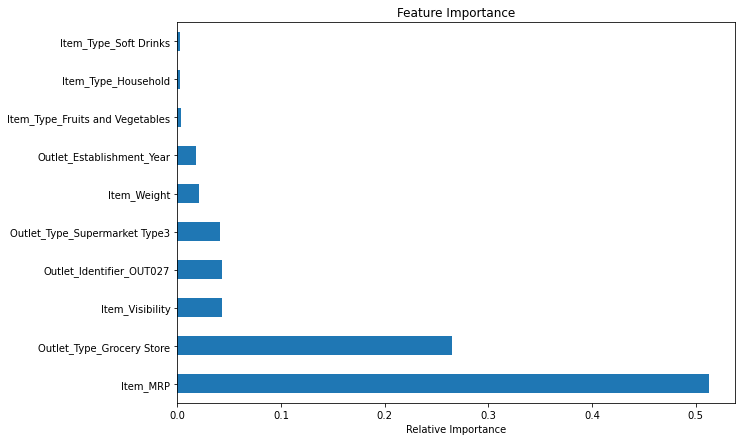

In [16]:
# Plot the top 10 most important features
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RF.feature_importances_, index=train_x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.title('Feature Importance');

In [17]:
# Retrain model with the top 10 featuers only

train_x_top10 = train_x[['Item_MRP', 
                         'Outlet_Type_Grocery Store',
                         'Item_Visibility',
                         'Outlet_Type_Supermarket Type3',
                         'Outlet_Establishment_Year',
                         'Outlet_Identifier_OUT027',
                         'Item_Weight',
                         'Item_Type_Fruits and Vegetables',
                         'Item_Type_Snack Foods',
                         'Item_Type_Soft Drinks']]

validate_x_top10 = validate_x[['Item_MRP', 
                               'Outlet_Type_Grocery Store',
                               'Item_Visibility',
                               'Outlet_Type_Supermarket Type3',
                               'Outlet_Establishment_Year',
                               'Outlet_Identifier_OUT027',
                               'Item_Weight',
                               'Item_Type_Fruits and Vegetables',
                               'Item_Type_Snack Foods',
                               'Item_Type_Soft Drinks']]

model_RF_top10 = RandomForestRegressor(max_depth=10, random_state=2)
model_RF_top10.fit(train_x_top10, train_y)

predict_train_top10 = model_RF_top10.predict(train_x_top10)
predict_validate_top10 = model_RF_top10.predict(validate_x_top10)

print('RMSE on train data: ', mean_squared_error(train_y, predict_train_top10)**(0.5))
print('RMSE on validate data: ', mean_squared_error(validate_y, predict_validate_top10)**(0.5))

RMSE on train data:  898.5252435455558
RMSE on validate data:  1117.152486739825


The RMSE values on train and validate data are about the same!  Let see if we can cut down the features to 7.  The Item_Type of Fruits and Vegetables, Snack Foods and Soft Drinks seem to have very low relative importance.  

In [18]:
train_x_top7 = train_x_top10.drop(['Item_Type_Fruits and Vegetables',
                                   'Item_Type_Snack Foods',
                                   'Item_Type_Soft Drinks'], 
                                  axis='columns')

validate_x_top7 = validate_x_top10.drop(['Item_Type_Fruits and Vegetables',
                                         'Item_Type_Snack Foods',
                                         'Item_Type_Soft Drinks'], 
                                        axis='columns')

model_RF_top7 = RandomForestRegressor(max_depth=10, random_state=2)
model_RF_top7.fit(train_x_top7, train_y)

predict_train_top7 = model_RF_top7.predict(train_x_top7)
predict_validate_top7 = model_RF_top7.predict(validate_x_top7)

print('RMSE on train data: ', mean_squared_error(train_y, predict_train_top7)**(0.5))
print('RMSE on validate data: ', mean_squared_error(validate_y, predict_validate_top7)**(0.5))

RMSE on train data:  899.9896566035051
RMSE on validate data:  1117.621725731451


Great!  The model performance is not compromised when the number of features reduced to 7.  